In [ ]:
# evaluate mlp for monthly car sales dataset

from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from time import time
from datetime import timedelta
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from sklearn.metrics import mean_squared_error



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  import sys


In [ ]:
def parser(x):
	return datetime.strptime(x, '%d-%b-%y')

In [ ]:

# split a univariate dataset into train/test sets
def train_test_split():
  train_end = datetime(2019,1,1)
  val_end = datetime(2020,6,1)
  test_end = datetime(2022,3,1)

  train_data = series[:train_end]
  val_data = series[train_end + timedelta(days=1):val_end]
  test_data = series[val_end + timedelta(days=1):test_end]

  return train_data.values, val_data.values,  test_data.values


In [ ]:
# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
  df = DataFrame(data)
  cols = list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
  # put it all together
  agg = concat(cols, axis=1)
  # drop rows with NaN values
  agg.dropna(inplace=True)
  return agg.values

In [ ]:
# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [ ]:
def measure_mse(actual, predicted):
    return mean_squared_error(actual, predicted)

In [ ]:
def measure_R2(actual, predicted):
  a,b,c=train_test_split()
  rolling_residuals = b - predicted
  ss_res = np.sum(rolling_residuals**2)
  ss_tot = np.sum(b**2)
  R_squared = 1 - (ss_res/ss_tot)
  print(R_squared)
  return R_squared

In [ ]:
def plotting(actual, predicted):
  pyplot.plot(actual)
  pyplot.plot(predicted)
  pyplot.show()


In [ ]:
# fit a model
def model_fit(train, config):
  # unpack config
  n_input, n_nodes, n_epochs, n_batch = config
  # prepare data
  data = series_to_supervised(train, n_input)
  train_x, train_y = data[:, :-1], data[:, -1]
  # define model
  model = Sequential()
  model.add(Dense(n_nodes, activation='relu', input_dim=n_input))
  model.add(Dense(1))
  model.compile(loss='mse', optimizer='adam')
  # fit
  model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
  return model

In [ ]:
# forecast with a pre-fit model
def model_predict(model, history, config):
  # unpack config
  n_input, _, _, _ = config
  # prepare data
  x_input = array(history[-n_input:]).reshape(1, n_input)
  # forecast
  yhat = model.predict(x_input, verbose=0)
  return yhat[0]

In [ ]:

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
  predictions = list()

  # split dataset
  train,val,test = train_test_split()
  # fit model
  model = model_fit(train, cfg)
  # seed history with training dataset
  history = [x for x in train]
  # step over each time-step in the val set
  for i in range(len(val)):
    # fit model and make forecast for history
    yhat = model_predict(model, history, cfg)
    # store forecast in list of predictions
    predictions.append(yhat)
    # add actual observation to history for the next loop
    history.append(val[i])
  # estimate prediction error

  error1 = measure_rmse(val, predictions)
  error2 = measure_mse(val, predictions)
  error3 = measure_R2(val, predictions)
  graph = plotting(val, predictions)
  print(' > %.3f' % error1)
  print(' > %.3f' % error2)
  print(' > %.3f' % error3)
  return error1,error2,error3


In [ ]:
# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=1):
  # fit and evaluate the model n times
  RMSE,MSE,R2= walk_forward_validation(data, n_test, config)
  RMSE_scores = [RMSE for _ in range(n_repeats)]
  MSE_scores = [MSE for _ in range(n_repeats)]
  R2_scores = [R2 for _ in range(n_repeats)]

  return RMSE_scores, MSE_scores, R2_scores

In [ ]:
# summarize model performance
def summarize_scores(name, scores):
  # print a summary
  scores_m, score_std = mean(scores), std(scores)
  print(name, scores_m, score_std)
  # box and whisker plot
  #pyplot.boxplot(scores)
  #pyplot.show()


In [ ]:
series = read_csv('/content/sample_data/Raspberry.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
data = series.values
series

Date
2010-11-19    2.40
2010-11-26    2.51
2010-12-03    2.24
2010-12-10    2.73
2010-12-17    3.32
              ... 
2022-01-28    2.67
2022-02-04    2.68
2022-02-11    2.48
2022-02-18    2.83
2022-02-25    2.79
Name: Price, Length: 589, dtype: float64

-0.3384800744666461


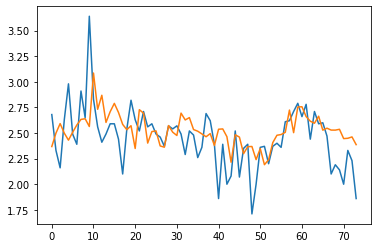

 > 0.278
 > 0.077
 > -0.338
mlp 0.27761306440173933 0.0
mlp 0.07706901352652427 0.0
mlp -0.3384800744666461 0.0


In [ ]:
# data split
n_test = 91
# define config
config = [74, 4, 1500, 100]
# grid search
RMSE_score,MSE_score,R2_score = repeat_evaluate(data, config, n_test)
# summarize scores
summarize_scores('mlp', RMSE_score)
summarize_scores('mlp', MSE_score)
summarize_scores('mlp', R2_score)


